# **Understanding the Data Science Job Market**

### **Setting the scene**

In this notebook, we investigate a data set of web scraped data science jobs from Glassdoor in February 2021, compiled by [Rashik Rahman](https://www.kaggle.com/rashikrahmanpritom), found on Kaggle [here](https://www.kaggle.com/rashikrahmanpritom/data-science-job-posting-on-glassdoor).
We initially do some high-level exploratory analysis, followed by a brief attempt to see whether a linear regression model can shed some light on the data science job market.

---

Summary:

*   The Tech sector is the top hirer of data science professionals followed by companies in the Business Services sector.
*   Python, SQL, Microsoft Excel, and Spark are the most mentioned skills in data science job descriptions.
*   Posted salary somewhat correlates with size of the company (in number of employees) and revenue generated.
*   Skills listed in the job description can barely explain the variance in the estimated salary.
*   However, the less mentioned the skill (the rarer it is), the higher its correlation with the predicted salary.


---

### **Importing required libraries and data**

First we import the libraries that we might need and take a glimpse at the data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import cm

import seaborn as sns
import plotly.express as px

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

import random

import json
%matplotlib inline

In [3]:
random.seed(0)
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [ ]:
!wget --no-check-certificate \
    'https://docs.google.com/spreadsheets/d/e/2PACX-1vQQPg9_DhCbQuz2t2EXJoiCgeOSA-0-jKZ6zk0XyBQlzFQMDFjdQILRPoNTm9K8l2xHS44Ke9KK_KUp/pub?gid=303885414&single=true&output=csv' \
    -O /tmp/dataset.csv

scraped_jobs_data = pd.read_csv('/tmp/dataset.csv', sep=',')

In [5]:
scraped_jobs_data.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Type of ownership,Industry,Sector,Revenue,min_salary,max_salary,avg_salary,job_state,same_state,company_age,python,excel,hadoop,spark,aws,tableau,big_data,job_simp,seniority
0,Sr Data Scientist,137-171,Description\n\nThe Senior Data Scientist is re...,3.1,Healthfirst,"New York, NY","New York, NY",1001 to 5000 employees,Nonprofit Organization,Insurance Carriers,Insurance,Unknown / Non-Applicable,137,171,154,NY,1,27,0,0,0,0,1,0,0,data scientist,senior
1,Data Scientist,137-171,"Secure our Nation, Ignite your Future\n\nJoin ...",4.2,ManTech,"Chantilly, VA","Herndon, VA",5001 to 10000 employees,Company - Public,Research & Development,Business Services,$1 to $2 billion (USD),137,171,154,VA,0,52,0,0,1,0,0,0,1,data scientist,na
2,Data Scientist,137-171,Overview\n\n\nAnalysis Group is one of the lar...,3.8,Analysis Group,"Boston, MA","Boston, MA",1001 to 5000 employees,Private Practice / Firm,Consulting,Business Services,$100 to $500 million (USD),137,171,154,MA,1,39,1,1,0,0,1,0,0,data scientist,na
3,Data Scientist,137-171,JOB DESCRIPTION:\n\nDo you have a passion for ...,3.5,INFICON,"Newton, MA","Bad Ragaz, Switzerland",501 to 1000 employees,Company - Public,Electrical & Electronic Manufacturing,Manufacturing,$100 to $500 million (USD),137,171,154,MA,0,20,1,1,0,0,1,0,0,data scientist,na
4,Data Scientist,137-171,Data Scientist\nAffinity Solutions / Marketing...,2.9,Affinity Solutions,"New York, NY","New York, NY",51 to 200 employees,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,137,171,154,NY,1,22,1,1,0,0,0,0,0,data scientist,na


In [6]:
scraped_jobs_data.describe()

,Rating,min_salary,max_salary,avg_salary,same_state,company_age,python,excel,hadoop,spark,aws,tableau,big_data
count,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000,660.000000
mean,3.587424,99.296970,148.301515,123.612121,0.407576,29.736364,0.730303,0.440909,0.212121,0.281818,0.260606,0.184848,0.206061
std,1.183540,33.161485,48.264588,39.786698,0.491756,39.763033,0.444139,0.496873,0.409120,0.450226,0.439298,0.388469,0.404781
min,0.000000,31.000000,56.000000,43.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.300000,79.000000,119.000000,103.000000,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.800000,91.000000,133.000000,114.000000,0.000000,16.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.300000,122.000000,165.000000,136.000000,1.000000,37.250000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,5.000000,212.000000,331.000000,271.000000,1.000000,239.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Address empty values
print('Proportion of empty values in dataset:')
print(scraped_jobs_data.isnull().sum() / scraped_jobs_data.count())

### **Questions to ask**


In our analysis of the data science job market, several key questions come to mind:

> 1.   Which sectors are hiring the most data science professionals at the moment?
>
> 2.   Which skills do hiring companies require from different data science professionals?
>
> 3.   Which skills tend to contribute the most to a higher estimated salary?
>
> 4.   Does the size of the company influence the estimated salary?
>

So let's try to answer the first question


### **Which sectors are hiring the most data science professionals at the moment?**
We attempt to answer this question by plotting a bar chart of number of job postings by sector. We use the job_simp column that shows a simplified version of the job title and ignoring unknown job titles. In addition, we ignore unannotated company sectors as they will serve no purpose in answering our question.





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa8c6df1d10>,
      dtype=object)

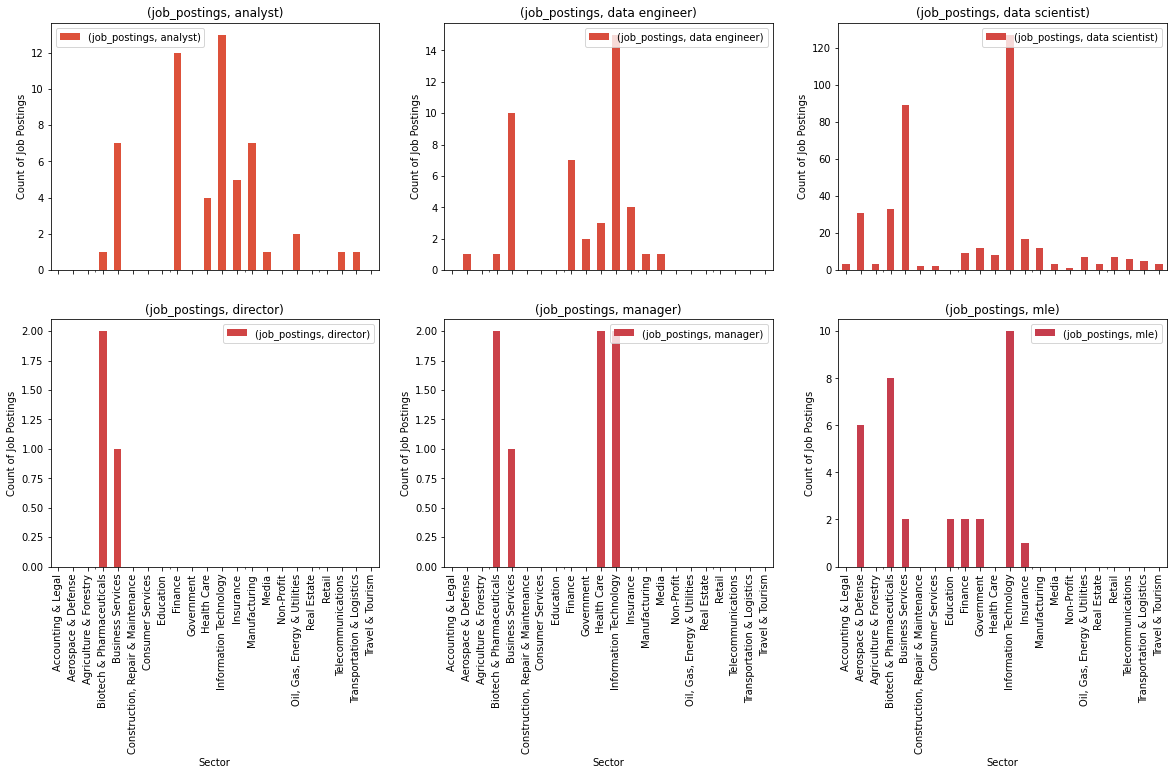

In [34]:
# Filter out unknown rows for target columns
scraped_jobs_data_cleaned = scraped_jobs_data.loc[(scraped_jobs_data['job_simp'] != 'na') & (scraped_jobs_data['Sector'] != '-1')].reset_index()

# Group by sector and simplified job titles for visualization
scraped_jobs_data_cleaned_grouped = scraped_jobs_data_cleaned[['job_simp', 'Sector', 'index']].groupby(['Sector', 'job_simp']).count()

# Rename index column for better readability
scraped_jobs_data_cleaned_grouped = scraped_jobs_data_cleaned_grouped.rename(columns={"index": "job_postings"})

# Customize the colours
color = cm.inferno_r(np.linspace(.4, .8, 30))

# Plot data science job postings by sector
scraped_jobs_data_cleaned_grouped.unstack().plot(kind='bar', subplots=True, layout=(2,3), figsize=(20,10), color=color, ylabel='Count of Job Postings')#, ylim=(0,130))

It appears that companies in the Information Technology sector are hiring the most data science professionals across all job types (except for data science directors).

Interestingly, companies engaged in the Business Services sector seem to be the second highest hirers of data science professionals. This is consistent across the two most popular job titles, i.e, data scientist and data engineer.

However, the demand for the third most popular job title (data analyst) is more evenly distributed across sectors relative to the other job titles.

### **Data Science Required Skills**

We now move on to answer the second question by looking at how often different data science skills were mentioned in the job descriptions of the scraped jobs.

Some skills were already highlighted in the cleaned data set of the scraped jobs. However, we attempt to add ore jobs to be analyzed as follows.

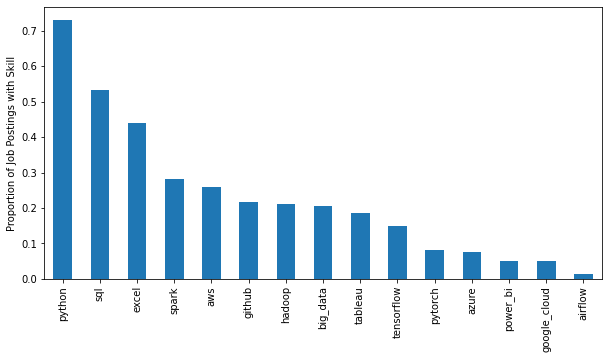

In [10]:
# Full list of skills to be analyzed
skills_to_be_analyzed = ['power_bi', 'tensorflow', 'pytorch', 'sql', 'airflow', 'azure', 'github', 'google_cloud', 'python', 'excel', 'hadoop', 'spark', 'aws', 'tableau', 'big_data']

# Adding a new variable to scraped dataset of job postings that identifies if the additional skills were mentioned
scraped_jobs_data['power_bi'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'power bi' in x.lower() else 0)
scraped_jobs_data['tensorflow'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'tensorflow' in x.lower() else 0)
scraped_jobs_data['pytorch'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'pytorch' in x.lower() else 0)
scraped_jobs_data['sql'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'sql' in x.lower() else 0)
scraped_jobs_data['airflow'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'airflow' in x.lower() else 0)
scraped_jobs_data['azure'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'azure' in x.lower() else 0)
scraped_jobs_data['github'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if 'git' in x.lower() else 0)
scraped_jobs_data['google_cloud'] = scraped_jobs_data['Job Description'].apply(lambda x: 1 if ('google cloud' in x.lower()) | ('gcp' in x.lower()) else 0)

# Calculating the proportion of job postings with skill to be analyzed
scraped_jobs_data[skills_to_be_analyzed].mean().sort_values(ascending=False).plot(kind='bar', figsize=(10,5), ylabel='Proportion of Job Postings with Skill')

#######################################################################################
# CODE BELOW CAN BE USED TO REPLOT THE ABOVE BUT AFTER GROUPING BY SIMPLIFIED JOB TITLE
#######################################################################################

# scraped_jobs_data_wo_na_titles = scraped_jobs_data.loc[scraped_jobs_data['job_simp'] != 'na']

# skills_to_be_analyzed.append('job_simp')
# skills_plus_job_title_columns = skills_to_be_analyzed

# scraped_jobs_data_skills_grouped = scraped_jobs_data_wo_na_titles[skills_plus_job_title_columns].groupby(['job_simp']).mean()

# scraped_jobs_data_skills_grouped.transpose().plot(kind='bar', subplots=True, layout=(2,3), figsize=(20,10), color=color, ylim=(0,0.9), ylabel='Proportion of Job Postings with Skill')

We can see that Python was the most mentioned skill in the job descriptions of scraped job postings. Interestingly, SQL was the second most mentioned skill, which is probably due to SQL being an essential (and legacy) tool for data analysis and wrangling across various data science functions (caters to a wider audience). Similarly, Microsoft Excel was the third most mentioned skill, owing to its versatility and popularity among different functions as an essential tool.
When comparing tools that serve somewhat the same purpose, AWS was more likely to be mentioned compared to Google Cloud Platform or Microsoft Azure. Similarly, Tableau was mentioned 4 times as much as Power BI and Tensorflow was mentioned 2 times more than PyTorch.

And now to answer the third question..

### **Which skills tend to contribute the most to a higher estimated salary?**

We attempt to answer the third question by building a linear regression model where the features are the flag parameters (added above) of whether or not a certain skill was mentioned in the job description. We attempt to rule out the effect of a job location on the estimated salary by only considering the jobs in the top location for this preliminary analysis.

[Text(0, 0.5, 'Features'), Text(0.5, 0, 'Importance in Predicting Salary')]

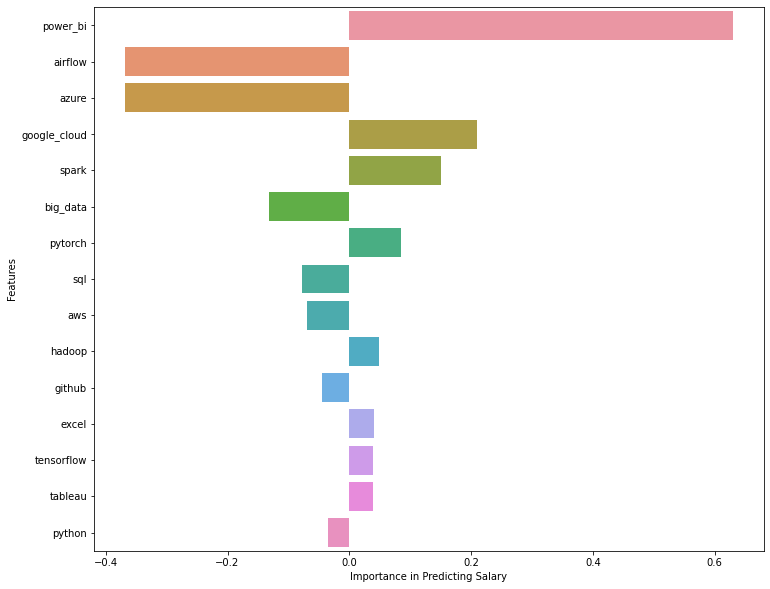

In [21]:
# Include only job postings in the top location to eliminate the location influence on estimated salary.
top_location = scraped_jobs_data['Location'].mode().values[0]
scraped_jobs_data_in_top_location = scraped_jobs_data.loc[scraped_jobs_data['Location'] == top_location]

# Normalize the average salary and divide dataset into features and target variables
X = scraped_jobs_data_in_top_location[skills_to_be_analyzed]
y = (scraped_jobs_data_in_top_location['avg_salary']-scraped_jobs_data_in_top_location['avg_salary'].min())/(scraped_jobs_data_in_top_location['avg_salary'].max()-scraped_jobs_data_in_top_location['avg_salary'].min())

# Split dataset to training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

# Developing a linear regression model to fit the training dataset
model = LinearRegression(normalize=True)
model.fit(X_train, y_train)

# Get model coefficients
model_coefficients = model.coef_

# Evaluate feature importance based on the training dataset
feature_importance_for_y = pd.DataFrame(data=model_coefficients, columns=['importance'])
feature_importance_for_y['feature'] = X.columns.tolist()

feature_importance_for_y['absolute_importance'] = feature_importance_for_y['importance'].abs()
feature_importance_for_y = feature_importance_for_y.sort_values('absolute_importance', ascending=False)

plt.figure(figsize=(12,10))
ax = sns.barplot(x="importance", y="feature", data=feature_importance_for_y)
ax.set(xlabel='Importance in Predicting Salary', ylabel='Features')

In [35]:
# We test our model against the test dataset and evaluating the R2 score and the mean squared error
y_test_preds = model.predict(X_test)

print("The R2 score for the model: " + str(r2_score(y_test, y_test_preds)))
print("The mean squared error for the model: " + str(mean_squared_error(y_test, y_test_preds)))

The R2 score for the model: 0.13325087183509388
The mean squared error for the model: 0.03752754418696062


From which we see that the model was only able to explain 13% of the variance (as evident by the R2 score). Nonetheless, having Power BI mentioned in the job description tended to correlate positively with the predicted salary. This compares to a significantly lower importance for when Tableau was mentioned in the job description.

However, it is worth noting that the rarer the skill being mentioned in the job description (as we have seen earlier), the higher its absolute importance in predicting the average salary.

And finally we move on to answer the fourth question..

### **Does the size of the company influence the estimated salary?**

We will answer this question by building a random forest and evaluating the permutation importance on the categorical columns of company size and revenue (in addition to other variables of importance) in predicting the average salary.

In [40]:
# Defining columns to be studied in building the random forest model
columns_to_be_studied = ['Rating', 'Location', 'Size', 'Type of ownership', 'Revenue', 'job_simp', 'seniority']

# Dividing the original dataset into features and target datasets
x_rf = scraped_jobs_data[columns_to_be_studied]
y_rf = scraped_jobs_data['avg_salary']

# Differentiating between categorical and numerical columns as a prerequisite for the preprocessing pipeline
categorical_columns = ["Location", "Size", "Type of ownership", "Revenue", 'job_simp', 'seniority']
numerical_columns = ["Rating"]

x_rf = x_rf[categorical_columns + numerical_columns]

# Dividing the dataset into training and testing dataset
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(x_rf, y_rf, stratify=y_rf, random_state=42)

# Defining the one hot encoder for categorical columns and the imputer for numerical columns
categorical_encoder = OneHotEncoder(handle_unknown="ignore")
numerical_pipe = Pipeline([("imputer", SimpleImputer(strategy="mean"))])

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", numerical_pipe, numerical_columns),
    ]
)

rf = Pipeline(
    [
        ("preprocess", preprocessing),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)
rf.fit(X_train_rf, y_train_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Location', 'Size',
                                                   'Type of ownership',
                                                   'Revenue', 'job_simp',
                                                   'seniority']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Rating'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [43]:
# Evaluating random forest performance on training and testing datasets
print("RF train R2 score: %0.3f" % rf.score(X_train_rf, y_train_rf))
print("RF test R2 score: %0.3f" % rf.score(X_test_rf, y_test_rf))

RF train R2 score: 0.802
RF test R2 score: 0.061


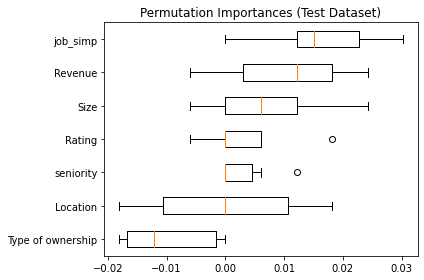

In [42]:
# Evaluating the permutation importance on columns to be studied in predicting salary

result = permutation_importance(
    rf, X_test_rf, y_test_rf, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(
    result.importances[sorted_idx].T, vert=False, labels=X_test_.columns[sorted_idx]
)
ax.set_title("Permutation Importances (Test Dataset)")
fig.tight_layout()
plt.show()

Evidently, the size of the company (by way of employee count) and revenue generated have the second and third top permutation importances among the studied feature set. Even though it explained only 6% of the variance in the testing dataset (due to overfitting). Naturally, the simplified job title was the best predictor of average salary.

### Final Thoughts

1.   It would be very useful to track data science job postings over time (and recreate this analysis) to provide greater insights on the temporal patterns associated with the data science job market.
2.   The larger the dataset of job postings the better equipped we are to reduce overfitting.
3.   There may be a little more feature cleaning we could do.
4.   We have done little feature engineering to see if that can improve the fit (i.e. many of the numerical features are not nice normal distributions, so maybe a transformation of them could help)


